# K channels: inactivation

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your K channel recordings in the "data/K_channels" folder

In [2]:
data_folder = "data/2-K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/2-K_channels


['data/2-K_channels/K_IV.abf',
 'data/2-K_channels/KTailCurrent.abf',
 'data/2-K_channels/K_deact_1.abf',
 'data/2-K_channels/K_deact_3.abf',
 'data/2-K_channels/K_deact_2.abf',
 'data/2-K_channels/2024_06_08_0007.abf',
 'data/2-K_channels/2024_06_08_0013.abf',
 'data/2-K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
# data_file = 'data/2-K_channels/2024_06_08_0007.abf'
# data_file = 'data/2-K_channels/2024_06_08_0014.abf'

data_file = 'data/2-K_channels/K_deact_3.abf'

Now we can load the file and plot the raw data:

Trace('K_deact_3.abf')
Number of sweeps: 11
Points per sweep: 28,500
Duration per sweep: 0.570 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage


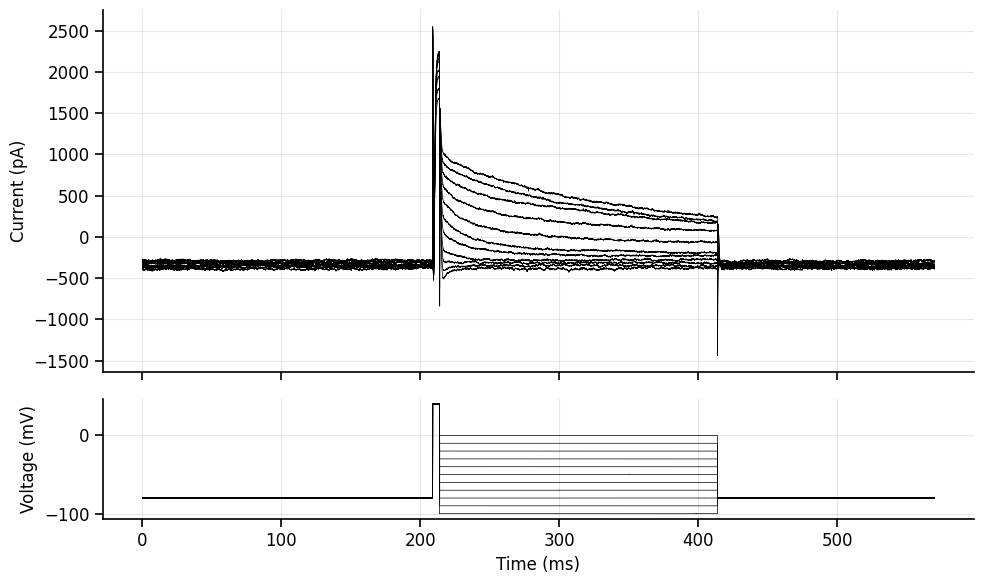

Voltage step time: [213.9] to [413.9] ms


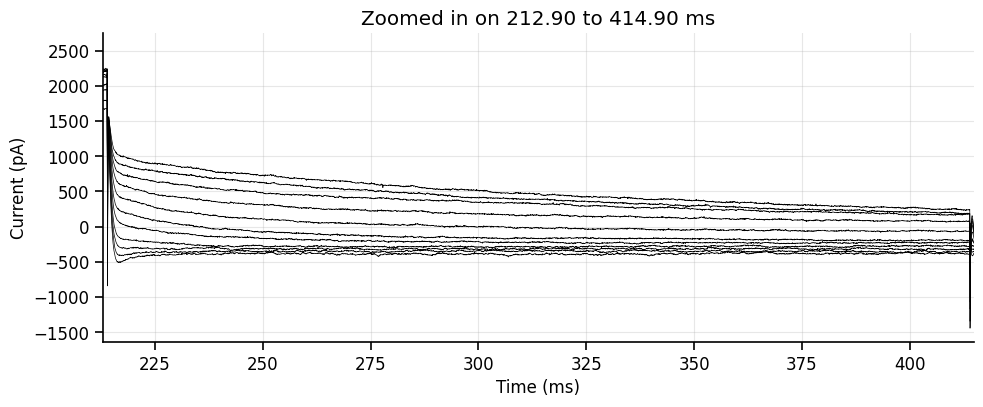

In [21]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=False,
                              units=['pA', 'mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)


# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
ax = traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

v_step_start_init = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
v_step_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
v_step_end = traces.get_step_events(threshold=traces.voltage_data[0,-1]-5, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
print(f"Voltage step time: {v_step_start} to {v_step_end} ms")
try:
    x_axis_range = (v_step_start[0]-1, v_step_end[0]+1)
except:
    x_axis_range = (v_step_start[0], v_step_end[0])

ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]:.2f} to {x_axis_range[1]:.2f} {time_units}')
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-288.1683 -289.8505 -312.5055 ... -357.2711 -373.0426 -371.6736]


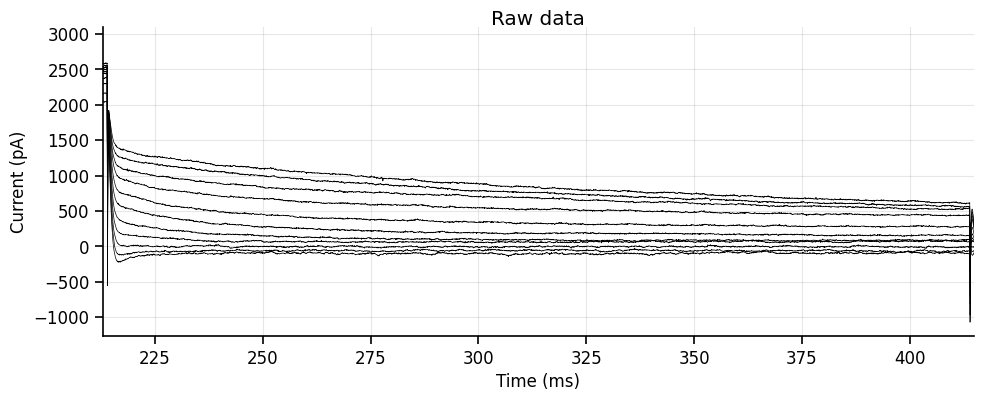

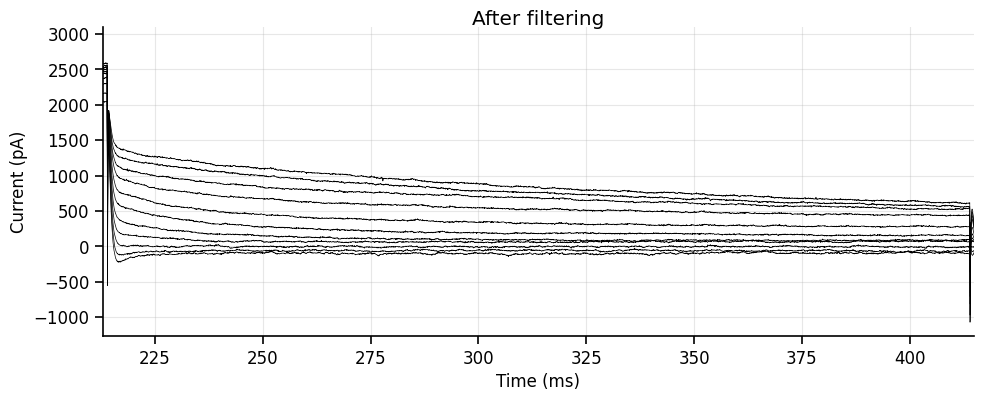

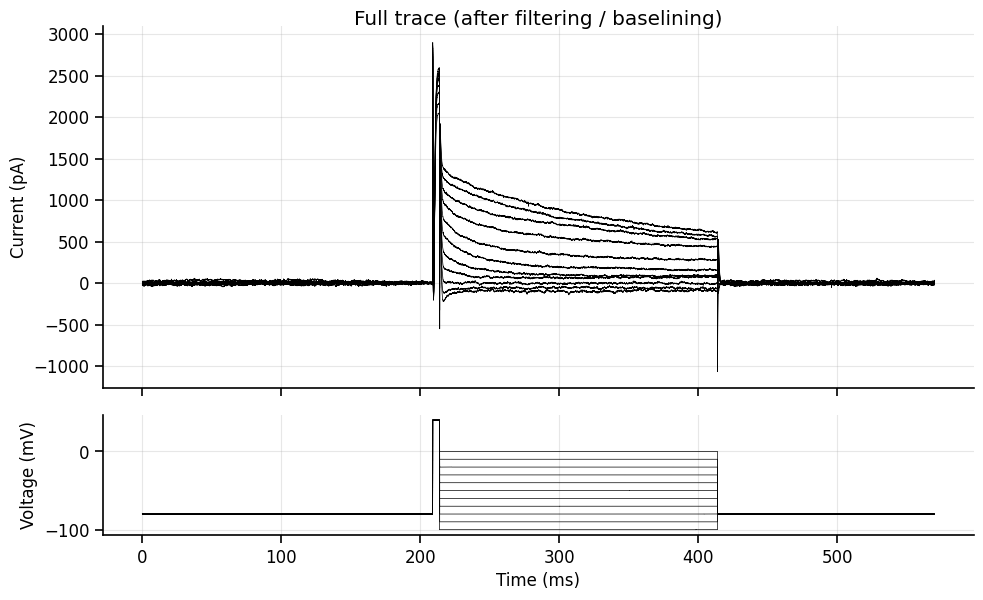

In [ ]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = max(0, v_step_start_init[0]-5)  # Start time for baseline subtraction
    end_baseline = v_step_start_init[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, time_units=time_units, sweep='all')
    ax[0].set_title('Full trace (after filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [23]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the instantaneous (tail) currents

The initial current just after the first pulse is when channels are most open, so we can use those values to plot the IV

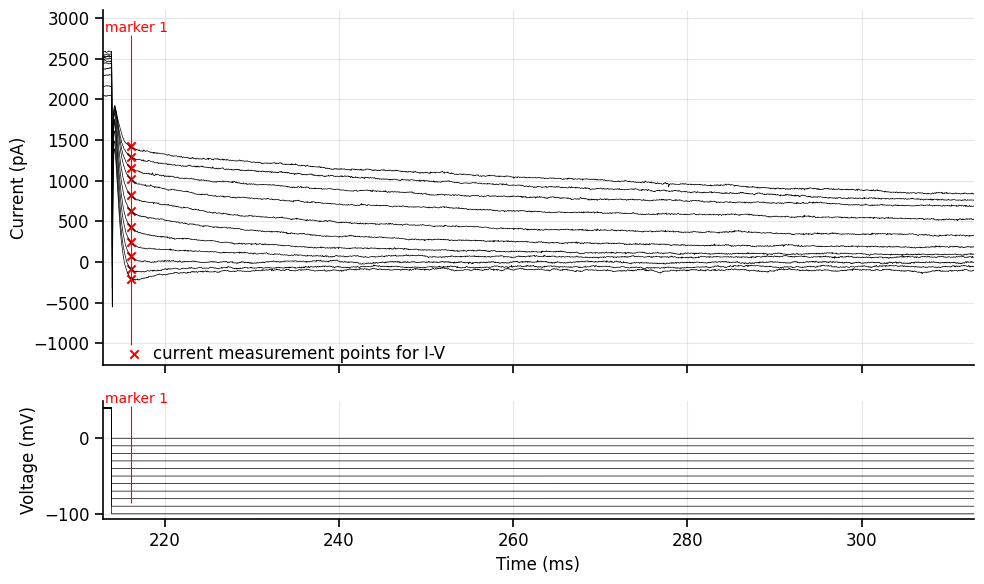

In [32]:
# The marker here will define the timepoint where we will measure current values
marker_1 = v_step_start[0] + 2.2

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, sweep='all')
ax1.set_xlim(x_axis_range[0], x_axis_range[0]+100)  # Extend the x-axis a bit to the right
ax2.set_xlim(x_axis_range[0], x_axis_range[0]+100)  # Extend the x-axis a bit to the right

current_steps ,voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_1+0.1, time_units=time_units, sweep='all', measurement_type='peak')
ax1.scatter([marker_1]*len(current_steps), current_steps, color='red', marker='x', label="current measurement points for I-V")
ax1.legend(loc='upper left', bbox_to_anchor=(0., 0.1))
plt.show()

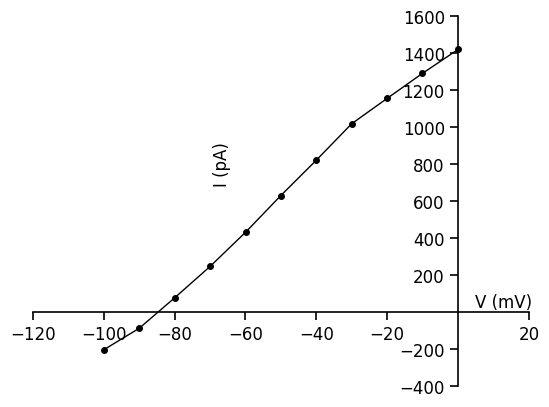

In [33]:
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))
plt.show()

### 3.2. Estimate the reversal potential and conductance by fitting a line to the I-V points

G = slope = 17.110 nS
Resistance = 1/slope = 58.444 MOhm
Reversal potential: -86.136 mV


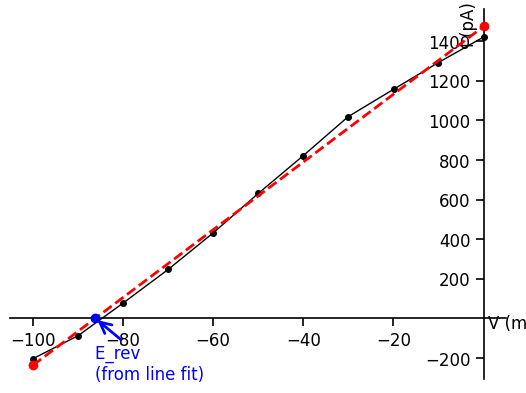

In [36]:
# Choose which range of point you want to fit a line to
# Here it is important to select a range of points in the "linear" (right) part of the IV curve, where the Na channels are open.

voltage_start = -100
voltage_end = +30

slope, intercept, E_rev = fit_IV_curve(voltage_steps, current_steps, voltage_start, voltage_end)

## 4. Measure the decay timeconstant of the currents 

Here we will fit an exponential to the current decay. The fit will be based on the traces between the two markers

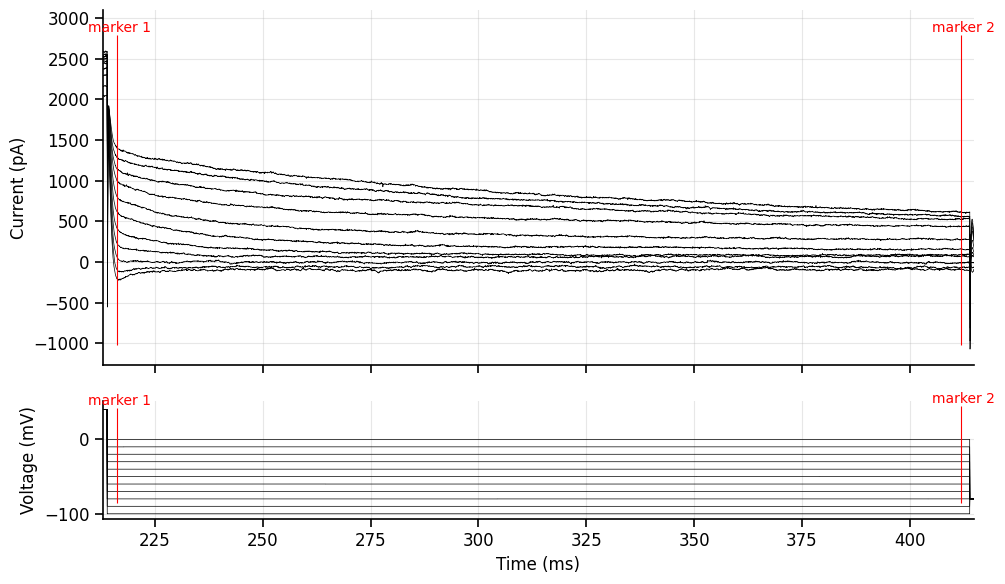

In [43]:
# The marker here will define the timepoint where we will measure current values
marker_1 = v_step_start[0] + 2.2
marker_2 = v_step_end[0] - 2

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(x_axis_range)
ax2.set_xlim(x_axis_range)
# ax1.set_xlim(x_axis_range[0], x_axis_range[0]+100)  # Extend the x-axis a bit to the right
# ax2.set_xlim(x_axis_range[0], x_axis_range[0]+100)  # Extend the x-axis a bit to the right
plt.show()

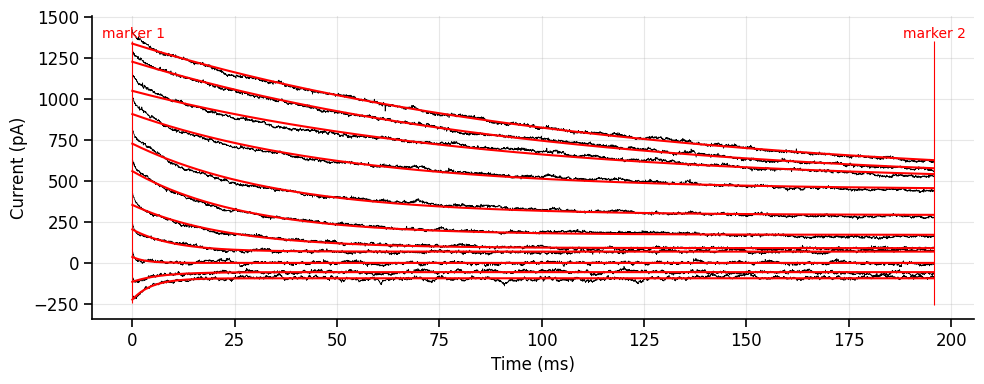

In [ ]:
# We need an initial guess for fitting the exponential curve
tau_guess = 100 # ms (if the fit doesn't work, try to change this value)

# If the fit still doesn't work, try to change the position of marker 1 or marker 2


# -----------------------------------------------------------------------------------------------------------------
cropped_traces = traces.crop(timepoint=marker_1, timepoint_2=marker_2, time_units=time_units)
ax = cropped_traces.plot(plot_voltage=False, time_units=time_units, marker_1=0, marker_2=(marker_2-marker_1), sweep='all')

current_between_markers = cropped_traces.current_data
voltage_steps = list(cropped_traces.voltage_data[:, 0])
time_ms = cropped_traces.time_ms

def exponential_curve(time, I0, tau, I_inf):
    return I0 * np.exp(-time / tau) + I_inf

tau_values = []
for i, trace in enumerate(current_between_markers):
    I0_guess = trace[0]
    I_inf_guess = trace[-1]
    try:
        fit_params,_ = curve_fit(exponential_curve, time_ms[0:], trace[0:], 
                                    p0=[I0_guess, tau_guess, I_inf_guess], maxfev=1000000)
        V0_fit, tau_fit, Vinf_fit = fit_params
        tau_values.append(tau_fit)

        if np.abs(tau_fit) > 1000: # Remove outliers (bad fits), we are not expecting a tau > 1 second for these currents
            tau_values.pop()
            voltage_steps.pop(i)

        # Overlay fit
        fit_trace = exponential_curve(time_ms[0:], *fit_params)
        ax.plot(time_ms[0:], fit_trace[0:], color='r', alpha=1, linewidth=1.5)
    except RuntimeError:
        print("Error fitting trace")
        tau_values.append(np.nan)
        continue
plt.show()

Finally, let's plot the the decay timeconstant vs the voltage steps applied.

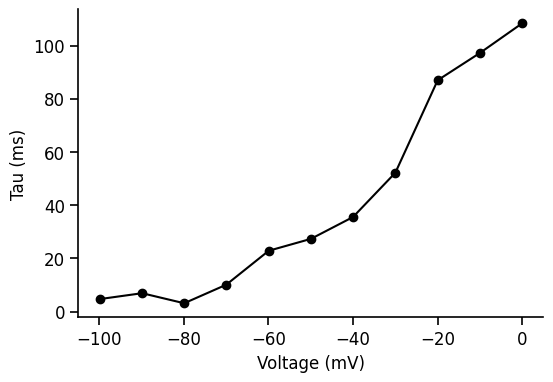

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(voltage_steps, tau_values, 'o-' ,color='black')
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.show()  